In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import wandb
from sklearn.decomposition import PCA
import GPUtil
import os
import itertools
from torch.utils.data import random_split

from torch.utils.data import DataLoader, TensorDataset

import random

# Loading the Data:
---

## CIFAR10:
---

Following [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) pytorch tutorial for using CIFAR10

In [2]:
# # Define the transformation to convert to grayscale and flatten to 1D
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert images to tensors
#     transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
#     transforms.Normalize((0.5,), (0.5,)),  # Normalize for grayscale
#     transforms.Lambda(lambda x: x.view(-1)),  # Flatten the image to 1D
# ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)

# # Define the size of the validation set as 20% of the training set
# val_size = int(len(trainset) * 0.2)
# train_size = len(trainset) - val_size

# # Split the dataset into training and validation sets
# train_subset, val_subset = random_split(trainset, [train_size, val_size])

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Define the size of the validation set as 20% of the training set
val_size = int(len(trainset) * 0.2)
train_size = len(trainset) - val_size

# Split the dataset into training and validation sets
train_subset, val_subset = random_split(trainset, [train_size, val_size])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
batch_size=4

Here are some of the images in the CIFAR10 dataset in greyscale:

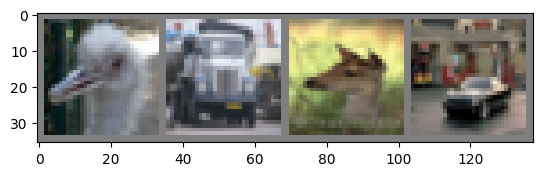

bird  truck deer  car  


In [5]:
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

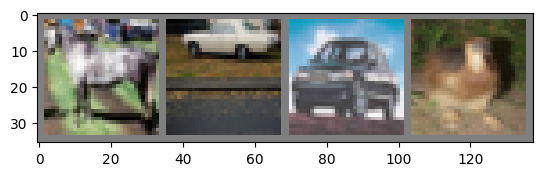

horse car   car   bird 


In [6]:
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## MNIST:
---

In [7]:
# Define the transformation to convert images to tensors and flatten to 1D
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to range [-1, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to 1D
])

# Load the MNIST training set
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)

val_size = int(len(trainset) * 0.2)
train_size = len(trainset) - val_size

# Split the dataset into training and validation sets
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Load the MNIST test set
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

# Create DataLoaders for the training and test sets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Check the size of the flattened images
for images, labels in trainloader:
    print(f'Batch image shape: {images.shape}')  # Should print (batch_size, 784) for 28x28 images
    print(f'Batch labels shape: {labels.shape}')  # Should print (batch_size,)
    break  # Remove this to process all batches

Batch image shape: torch.Size([64, 784])
Batch labels shape: torch.Size([64])


# Definitions:
---

In [8]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [9]:
def update_wandb_kwargs(wandb_kwargs, updates):
    for key in updates.keys():
        wandb_kwargs[key] = updates[key]
    return wandb_kwargs

In [32]:
def train_one_epoch(train_dataset, device, model, criterion, optimizer, epoch, combo):
  epoch_training_loss = 0

  predicted_embeddings = []
  output_name_encodings = []

  for batch, name_encodings, true_embeddings in train_dataset:
    # move inputs to device
    batch = batch.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # backprapogation
    optimizer.zero_grad()

    # forward pass
    batch_predicted_embeddings = model(batch)

    loss = criterion(batch_predicted_embeddings, true_embeddings)
    # accumulate epoch training loss
    epoch_training_loss += loss.item()

    loss.backward()
    optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == combo['epochs']:
      output_name_encodings.append(name_encodings)
      predicted_embeddings.append(batch_predicted_embeddings)

  # divide by number of batches to calculate average loss
  average_loss = epoch_training_loss/len(train_dataset)
  if (epoch + 1) == combo['epochs']:
    return average_loss, predicted_embeddings, output_name_encodings
  else:
    return average_loss

In [43]:
def preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, emb_df, mass_spec_encoder_embeddings=False, mass_spec_chems=False):
    """
    Generate and plot a PCA visualization of predicted embeddings against corresponding ChemNet embeddings.

    Parameters:
    ----------
    predicted_embeddings : list of list of torch.Tensor
        A nested list of predicted embeddings, where each inner list contains tensors for a batch.

    output_name_encodings : list of list of torch.Tensor
        A nested list of one-hot encoded tensors representing the chemical names for the predicted embeddings.

    sorted_chem_names : list of str
        A list of chemical names corresponding to the indices of the one-hot encodings.

    emb_df : pandas.DataFrame
        A DataFrame containing true embeddings, with 'Embedding Floats' as one of its columns.

    log_wandb : boolean 
        True - log plot to wandb. False - do not log plot to wandb.

    Returns:
    -------
    A tuple containing:
    - true_embeddings (pd.DataFrame): DataFrame of true embeddings used for comparison.
    - predicted_embeddings_flattened (list): Flattened list of predicted embeddings.
    - chem_names (list): List of chemical names corresponding to the predicted embeddings.
    """

    # Currently, preds and name encodings are lists of [n_batches, batch_size], flattening to lists of [n_samples]
    predicted_embeddings_flattened = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
    chem_name_encodings_flattened = [enc.cpu() for enc_list in output_name_encodings for enc in enc_list]

    # Get chemical names from encodings
    chem_names = [sorted_chem_names[int(encoding)] for encoding in chem_name_encodings_flattened]

    if mass_spec_encoder_embeddings:
        for emb in mass_spec_encoder_embeddings:
            predicted_embeddings_flattened.append(torch.Tensor(emb))
        chem_names += mass_spec_chems

    # making list of all embeddings and chem names except for BKG
    embeddings = [emb for emb in emb_df['Embedding Floats']][1:]
    cols = emb_df.index[1:]
    true_embeddings = pd.DataFrame(embeddings).T
    true_embeddings.columns = cols
    
    return (true_embeddings, predicted_embeddings_flattened, chem_names)

In [30]:
def train_model(
        encoder, train_data, val_data, device, config, wandb_kwargs, embedding_df, 
        model_hyperparams, sorted_chem_names, encoder_path, save_emb_pca_to_wandb = True):

    # loss to compare for each model. Starting at infinity so it will be replaced by first model's first epoch loss 
    lowest_val_loss = np.inf

    keys = model_hyperparams.keys()
    values = model_hyperparams.values()

    # Generate all parameter combinations from model_config using itertools.product
    combinations = itertools.product(*values)

    # Iterate through each parameter combination and run model 
    for combo in combinations:
        combo = dict(zip(keys, combo))

        train_dataset = DataLoader(train_data, batch_size=combo['batch_size'], shuffle=True)
        val_dataset = DataLoader(val_data, batch_size=combo['batch_size'], shuffle=False)

        encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = combo['learning_rate'])
        encoder_criterion = nn.MSELoss()

        wandb_kwargs = update_wandb_kwargs(wandb_kwargs, combo)

        run_with_wandb(config, **wandb_kwargs)

        print('--------------------------')
        print('--------------------------')
        print('New run with hyperparameters:')
        for key in combo:
            print(key, ' : ', combo[key])

        for epoch in range(combo['epochs']):
            encoder.train(True)

            # do a pass over the data
            # at last epoch get predicted embeddings and chem names
            if (epoch + 1) == combo['epochs']:
                average_loss, predicted_embeddings, output_name_encodings = train_one_epoch(
                train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
                )
            else:
                average_loss = train_one_epoch(
                train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
                )

            epoch_val_loss = 0  
            # evaluate model on validation data
            encoder.eval() # Set model to evaluation mode
            with torch.no_grad():
                for val_batch, val_name_encodings, val_true_embeddings in val_dataset:
                    val_batch = val_batch.to(device)
                    val_name_encodings = val_name_encodings.to(device)
                    val_true_embeddings = val_true_embeddings.to(device)

                    val_batch_predicted_embeddings = encoder(val_batch)

                    val_loss = encoder_criterion(val_batch_predicted_embeddings, val_true_embeddings)
                    # accumulate epoch validation loss
                    epoch_val_loss += val_loss.item()

            # divide by number of batches to calculate average loss
            val_average_loss = epoch_val_loss/len(val_dataset)

            if val_average_loss < lowest_val_loss:
                lowest_val_loss = val_average_loss
                best_epoch = epoch + 1  # Store the best epoch
                # Save the model state
                torch.save(encoder.state_dict(), encoder_path)
                best_hyperparams = combo
                print(f'Saved best model at epoch {best_epoch}')

            # log losses to wandb
            wandb.log({"Encoder Training Loss": average_loss, "Encoder Validation Loss": val_average_loss})

            if (epoch + 1) % 10 == 0:
                print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
                print(f'   Training loss: {average_loss}')
                print(f'   Validation loss: {val_average_loss}')
                print('-------------------------------------------')

        if save_emb_pca_to_wandb:
            # true_embeddings, predicted_embeddings_flattened, chem_names = 
            preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, embedding_df)

        # at last epoch print model architecture details (this will also show up in wandb log)
        if (epoch+1) == combo['epochs']:
            print('-------------------------------------------')
            print('-------------------------------------------')
            print('Dataset: ', wandb_kwargs['dataset'])
            print('Target Embeddings: ', wandb_kwargs['target_embedding'])
            print('-------------------------------------------')
            print('-------------------------------------------')
            print(encoder)
            print('-------------------------------------------')
            print('-------------------------------------------')

        wandb.finish()

    print('Hyperparameters for best model: ')
    for key in best_hyperparams:
        print('   ', key, ' : ', best_hyperparams[key])
    
    return best_hyperparams


In [13]:
def predict_embeddings(dataset, model, device, criterion):
    total_loss = 0

    model.eval() # Set model to evaluation mode
    predicted_embeddings = []
    output_name_encodings = []

    with torch.no_grad():
        for batch, name_encodings, true_embeddings in dataset:
            batch = batch.to(device)
            true_embeddings = true_embeddings.to(device)

            batch_predicted_embeddings = model(batch)
            predicted_embeddings.append(batch_predicted_embeddings)
            output_name_encodings.append(name_encodings)

            loss = criterion(batch_predicted_embeddings, true_embeddings)
            # accumulate loss
            total_loss += loss.item()

    # divide by number of batches to calculate average loss
    average_loss = total_loss/len(dataset)
    return predicted_embeddings, output_name_encodings, average_loss

In [14]:
# class Encoder(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.encoder = nn.Sequential(
#       nn.Linear(1024, 908),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(908, 780),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(780, 652),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(652, 512),
#     )

#   def forward(self, x):
#     x = self.encoder(x)
#     return x

In [15]:
# class Encoder(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.encoder = nn.Sequential(
#       nn.Linear(3072,2787),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(2787,2502),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(2502,2217),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(2217, 1932),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(1932, 1647),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(1647, 1362),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(1362, 1077),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(1077, 792),
#       nn.LeakyReLU(inplace=True),
#       nn.Linear(792, 512),
#     )

#   def forward(self, x):
#     x = self.encoder(x)
#     return x

In [16]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(784, 716),
      nn.LeakyReLU(inplace=True),
      nn.Linear(716, 648),
      nn.LeakyReLU(inplace=True),
      nn.Linear(648, 580),
      nn.LeakyReLU(inplace=True),
      nn.Linear(580, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [17]:
def plot_emb_pca(all_embeddings, ims_embeddings, mass_spec_embeddings = None, log_wandb=True, chemnet_embeddings_to_plot=None, title=None, mse_insert=None):
    """
    Perform PCA on chemical embeddings and plot the transformed data, including IMS and Mass Spec embeddings if provided.

    Parameters:
    ----------
    all_embeddings : pd.DataFrame
        A dataframe containing ChemNet embeddings for all chemicals. 
        Each column represents one chemical's ChemNet embedding.
    ims_embeddings : pd.DataFrame
        A dataframe containing IMS (ion mobility spectrometry) embeddings. Must include a 'Label' column
        with chemical names and additional columns for embedding features.
    mass_spec_embeddings : pd.DataFrame, optional
        A dataframe containing mass spectrometry embeddings. Similar structure to `ims_embeddings`.
        Default is None, meaning mass spec embeddings are not included.
    log_wandb : bool, optional
        If True, logs the generated plot to Weights and Biases (wandb). Default is True.
    chemnet_embeddings_to_plot : pd.DataFrame, optional
        A dataframe containing ChemNet embeddings for all chemicals TO BE PLOTTED. 
        Each column represents one chemical's ChemNet embedding.

    Returns:
    -------
    None
        Displays the PCA scatter plot with ChemNet, IMS, and Mass Spec embeddings. 
        Optionally logs the plot to wandb if `log_wandb` is True.

    Notes:
    -----
    - PCA is performed on the transpose of `all_embeddings` so that embeddings for ims and mass spec data can be plotted to the same space.
    """ 
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    if chemnet_embeddings_to_plot is not None:
        transformed_embeddings = pca.transform(chemnet_embeddings_to_plot.T)
        all_chemical_names = list(chemnet_embeddings_to_plot.columns)
    else:
        transformed_embeddings = pca.transform(all_embeddings.T) 
        all_chemical_names = list(all_embeddings.columns)

    _, ax = plt.subplots(figsize=(8,6))

    # Create a color cycle for distinct colors
    color_cycle = plt.gca()._get_lines.prop_cycler

    ims_labels = list(ims_embeddings['Label'])
    if mass_spec_embeddings is not None:
        mass_spec_labels=list(mass_spec_embeddings['Label'])
    else:
        mass_spec_labels = False
    
    # Scatter plot
    for chem in all_chemical_names:
        idx = all_chemical_names.index(chem)
        color = next(color_cycle)['color']
        # only label 1st 8 chemicals to avoid giant legend
        # ax.scatter(0,0, color = color, label=chem)
        if idx < 8:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color, label=chem)#, s=200)
        else:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color)#, s=75)
        # Transform ims_embeddings for the current chemical, if we have ims data for chem
        if chem in ims_labels:
            # transform all data for the given chemical. Exclude last col (label)
            ims_transformed = pca.transform(ims_embeddings[ims_embeddings['Label'] == chem].iloc[:, :-1])
            
            # Scatter plot for ims_embeddings with a different marker
            ax.scatter(ims_transformed[:, 0], ims_transformed[:, 1], marker='o', facecolors='none', edgecolors=color)#marker='x', color=color)#, s=75)
        # repeat for mass spec
        if mass_spec_labels:
            if chem in mass_spec_labels:
                # transform all data for the given chemical. Exclude last col (label)
                mass_spec_transformed = pca.transform(mass_spec_embeddings[mass_spec_embeddings['Label'] == chem].iloc[:, :-1].values)
                
                # Scatter plot for mass_spec_embeddings with a different marker
                ax.scatter(mass_spec_transformed[:, 0], mass_spec_transformed[:, 1], marker='*', color=color, s=75)
    # Add legend
    legend1 = ax.legend(loc='upper right', title='Label')
    ax.add_artist(legend1)

    marker_legends = [
    plt.Line2D([0], [0], marker='o', color='w', label='ChemNet', markerfacecolor='black', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='IMS', markerfacecolor='none', markeredgecolor='black', markersize=6),
    ]
    
    if mass_spec_embeddings is not None:
        marker_legends.append(plt.Line2D([0], [0], marker='*', color='w', label='Mass Spec', markerfacecolor='black', markersize=10))

    # Add the second legend
    legend2 = ax.legend(handles=marker_legends, title='Marker Types', loc='upper left')
    ax.add_artist(legend2)

    if mse_insert is not None:
        # Add mse text in the corner with a box
        plt.text(0.05, 0.05, f'MSE: {format(mse_insert, ".2e")}', 
            transform=plt.gca().transAxes,  # Use axis coordinates
            fontsize=14,
            verticalalignment='bottom',  # Align text to the top
            horizontalalignment='left',  # Align text to the right
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))  # Box properties

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, fontsize=18)
    else:
        plt.title('ChemNet vs. Encoder Output PCA', fontsize=18)

    if log_wandb:
        plt.savefig('tmp_plot.png', format='png', dpi=300)
        wandb.log({'PCA of Predicted Chemical Embeddings': wandb.Image('tmp_plot.png')})

    plt.show()

In [18]:
def create_dataset_tensors(images, embedding_df, labels, encodings, device):
    image_tensor = torch.stack(images).to(device)
    embeddings_tensor = torch.Tensor([embedding_df['Embedding Floats'][chem_name] for chem_name in labels]).to(device)
    chem_encodings_tensor = torch.Tensor(encodings).to(device)

    return embeddings_tensor, image_tensor, chem_encodings_tensor


# Setup:
---

## GPU:
---

In [19]:
if torch.cuda.is_available():
    # Get the list of GPUs
    gpus = GPUtil.getGPUs()

    # Find the GPU with the most free memory
    best_gpu = max(gpus, key=lambda gpu: gpu.memoryFree)

    # Print details about the selected GPU
    print(f"Selected GPU ID: {best_gpu.id}")
    print(f"  Name: {best_gpu.name}")
    print(f"  Memory Free: {best_gpu.memoryFree} MB")
    print(f"  Memory Used: {best_gpu.memoryUsed} MB")
    print(f"  GPU Load: {best_gpu.load * 100:.2f}%")

    # Set the device for later use
    device = torch.device(f'cuda:{best_gpu.id}')
    print('Current device ID: ', device)

    # Set the current device in PyTorch
    torch.cuda.set_device(best_gpu.id)
else:
    device = torch.device('cpu')
    print('Using CPU')

# Confirm the currently selected device in PyTorch
print("PyTorch current device ID:", torch.cuda.current_device())
print("PyTorch current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Selected GPU ID: 1
  Name: NVIDIA GeForce RTX 4090
  Memory Free: 24203.0 MB
  Memory Used: 14.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:1
PyTorch current device ID: 1
PyTorch current device name: NVIDIA GeForce RTX 4090


## Embeddings:
---

In [20]:
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

In [21]:
# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


Currently embeddings are strings instead of a list of floats. Would be good to fix that in preprocessing.

In [22]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

In [23]:
file_path = '../data/MoNA_embeddings_multiple_instrument_types.csv'
mass_spec_embeddings = pd.read_csv(file_path)

ims_embeddings = pd.DataFrame([emb for emb in name_smiles_embedding_df['Embedding Floats']][1:]).T
cols = name_smiles_embedding_df.index[1:]
ims_embeddings.columns = cols

all_true_embeddings = pd.concat([ims_embeddings, mass_spec_embeddings], axis=1)
all_true_embeddings.head()

,DEM,DEB,MES,DMMP,DPM,JP8,TEPO,DtBP,Succinic Acid,Spermidine,...,Benzyl Benzoate,1-Hexanol,Methyl Benzoate,Methyl Octadecanoate,1-Octanol,Isopentyl Acetate,Methyl Hexanoate,2-Octanol,Benzyl Alcohol,Testosterone
0,0.380972,0.063188,-0.325208,0.121068,-0.023968,0.025142,0.193039,0.226090,0.064590,-0.182374,...,0.093463,-0.231596,0.049136,0.169639,-0.259974,0.103226,0.045634,-0.243301,-0.366510,-0.028562
1,0.000545,0.009022,0.009838,0.002942,0.002720,0.011977,0.000974,0.000808,0.035480,0.002277,...,0.000235,0.001129,0.000574,0.005854,0.002117,0.001559,0.001912,0.004697,-0.000158,0.063791
2,0.255397,0.421601,-0.151083,-0.144505,0.158301,0.542705,0.066288,-0.062160,-0.251732,0.435204,...,0.013350,0.210704,-0.029098,-0.123646,0.109338,-0.037378,0.023809,-0.108382,0.207986,-0.061395
3,-0.242728,0.195723,0.284503,0.072665,-0.010084,0.364973,-0.195223,-0.045343,0.044983,0.452695,...,0.649366,-0.178973,0.387316,-0.355687,-0.293758,-0.109588,-0.288562,-0.401711,0.565014,-0.363461
4,-0.305106,-0.167326,-0.099838,-0.107286,-0.067723,-0.236272,-0.272051,-0.075880,-0.010591,-0.019926,...,-0.198024,-0.051284,-0.031114,-0.038610,-0.051176,-0.136067,-0.057799,-0.045440,-0.020714,-0.457587


## Images:
---

### CIFAR10:
---

In [45]:
# there are 8 classes in the simulant dataset. Excluding 'ship' and 'truck' from cifar10 so there will be 8 classes in this dataset as well.
exclude_classes = {8, 9}

# labeling images as chemical names instead of true class
chemicals = ['DEB', 'DEM', 'DMMP', 'DPM', 'DtBP', 'JP8', 'MES', 'TEPO']

# could I do this for the entire dataset instead of just first 10? images, labels = zip(*[train_subset[i] for i in range(10)])
train_images = [element[0] for element in train_subset if not element[1] in exclude_classes]
train_encodings = [element[1] for element in train_subset if not element[1] in exclude_classes]
train_labels = [chemicals[element[1]] for element in train_subset if not element[1] in exclude_classes]

val_images = [element[0] for element in val_subset if not element[1] in exclude_classes]
val_encodings = [element[1] for element in val_subset if not element[1] in exclude_classes]
val_labels = [chemicals[element[1]] for element in val_subset if not element[1] in exclude_classes]

test_images = [element[0] for element in testset if not element[1] in exclude_classes]
test_encodings = [element[1] for element in testset if not element[1] in exclude_classes]
test_labels = [chemicals[element[1]] for element in testset if not element[1] in exclude_classes]

In [46]:
print(len(train_images))
train_images[0].shape

31996


torch.Size([3, 32, 32])

In [47]:
def flatten_img(data, exclude_classes):
    # Initialize an empty list to store flattened images
    flattened_images = []
    labels = []

    # Iterate through the dataset and flatten the images
    for img, label in data:
        if not label in exclude_classes:
            # Flatten the image while keeping the color channels
            flattened_img = img.view(-1)  # Flatten to 1D
            flattened_images.append(flattened_img)
            labels.append(chemicals[label])

    return flattened_images, labels

exclude_classes = {8, 9}
train_images, train_labels = flatten_img(train_subset, exclude_classes)
val_images, val_labels = flatten_img(val_subset, exclude_classes)
test_images, test_labels = flatten_img(testset, exclude_classes)

In [48]:
train_embeddings_tensor, train_image_tensor, train_chem_encodings_tensor = create_dataset_tensors(
    train_images, 
    name_smiles_embedding_df,
    train_labels, 
    train_encodings,
    device
    )

val_embeddings_tensor, val_image_tensor, val_chem_encodings_tensor = create_dataset_tensors(
    val_images, 
    name_smiles_embedding_df,
    val_labels, 
    val_encodings,
    device
    )

test_embeddings_tensor, test_image_tensor, test_chem_encodings_tensor = create_dataset_tensors(
    test_images, 
    name_smiles_embedding_df,
    test_labels, 
    test_encodings,
    device
    )

In [50]:
# # Function to display images
# def show_images(images, labels, classes):
#     plt.figure(figsize=(10, 5))
#     for i in range(10):  # Display 10 images
#         plt.subplot(2, 5, i + 1)
#         img = images[i].view(1, 32, 32).numpy()  # Reshape back to (1, 32, 32)
#         plt.imshow(img[0], cmap='gray')  # Show grayscale image
#         plt.title(classes[labels[i]])  # Show the label
#         plt.axis('off')  # Turn off axis
#     plt.tight_layout()
#     plt.show()

# # Get a batch of images and labels from the training subset
# images, labels = zip(*[train_subset[i] for i in range(10)])  # Get the first 10 images and labels

# # Convert to tensors
# images = torch.stack(train_images[:10])
# labels = torch.tensor(train_encodings[:10])

# # Show the images
# show_images(images, labels, classes)

### MNIST:
---

#### Correct Labels:
---

In [24]:
# seed = 42  # You can choose any integer as your seed
# torch.manual_seed(seed)  # Set seed for PyTorch
# np.random.seed(seed)      # Set seed for NumPy
# random.seed(seed)  

In [25]:
# # labeling images as chemical names instead of true class. Excluding DPM because it is too close to DEM
# chemicals = ['DEB', 'DEM', 'DMMP', 'DtBP', 'JP8', 'MES', 'TEPO']

# def get_img_label_lists(data, chemicals, noise_factor=.2):
#     # there are 8 classes in the simulant dataset, 7 after removing DPM. Excluding '5', '7' and '9' from MNIST so there will be 7 classes in this dataset as well.
#     exclude_classes = [5, 7, 9]

#     images = []
#     encodings = []
#     labels = []

#     for image, label in data:
#         if not label in exclude_classes:
#             for i in range(100):
#                 noise = torch.randn_like(image) * noise_factor  # Generate random noise
#                 noisy_image = image + noise  # Add noise to the image
#                 noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure pixel values remain between 0 and 1
#                 images.append(noisy_image)
#                 encodings.append(label)
#                 labels.append(chemicals[label])
#                 exclude_classes.append(label)
#     return images, encodings, labels

# all_images, all_encodings, all_labels = get_img_label_lists(train_subset, chemicals, noise_factor=.5)
# # train_images, train_encodings, train_labels = get_img_label_lists(train_subset, chemicals)
# # val_images, val_encodings, val_labels = get_img_label_lists(val_subset, chemicals)
# # test_images, val_encodings, val_labels = get_img_label_lists(val_subset, chemicals)


In [26]:
# # labeling images as chemical names instead of true class. Excluding DPM because it is too close to DEM
# chemicals = ['DEB', 'DEM', 'DMMP', 'DtBP', 'JP8', '_', 'MES', '_', 'TEPO']

# # there are 8 classes in the simulant dataset, 7 after removing DPM. Excluding '5', '7' and '9' from MNIST so there will be 7 classes in this dataset as well.
# exclude_classes = [5, 7, 9]

# labeling images as chemical names instead of true class.
# chemicals = ['DEB', 'DEM', 'DMMP', 'DPM', 'DtBP', 'JP8', 'MES', 'TEPO']

# arranging simulant names so that more "similar" numbers (like 1 and 7) are represented by more similar chemicals (like DEM and DPM). 
# Very informal, just to see if this idea is worth looking into
#              0      1       2      3      4      5       6       7      
chemicals = ['MES', 'DPM', 'TEPO', 'DEB', 'JP8', 'DtBP', 'DMMP', 'DEM']

# there are 8 classes in the simulant dataset,. Excluding '8' and '9' from MNIST so there will be 8 classes in this dataset as well.
exclude_classes = [8, 9]

# could I do this for the entire dataset instead of just first 10? images, labels = zip(*[train_subset[i] for i in range(10)])
train_images = [element[0] for element in train_subset if not element[1] in exclude_classes]
train_encodings = [element[1] for element in train_subset if not element[1] in exclude_classes]
train_labels = [chemicals[element[1]] for element in train_subset if not element[1] in exclude_classes]

val_images = [element[0] for element in val_subset if not element[1] in exclude_classes]
val_encodings = [element[1] for element in val_subset if not element[1] in exclude_classes]
val_labels = [chemicals[element[1]] for element in val_subset if not element[1] in exclude_classes]

test_images = [element[0] for element in testset if not element[1] in exclude_classes]
test_encodings = [element[1] for element in testset if not element[1] in exclude_classes]
test_labels = [chemicals[element[1]] for element in testset if not element[1] in exclude_classes]

In [27]:
train_embeddings_tensor, train_image_tensor, train_chem_encodings_tensor = create_dataset_tensors(
    train_images, 
    name_smiles_embedding_df,
    train_labels, 
    train_encodings,
    device
    )

val_embeddings_tensor, val_image_tensor, val_chem_encodings_tensor = create_dataset_tensors(
    val_images, 
    name_smiles_embedding_df,
    val_labels, 
    val_encodings,
    device
    )

test_embeddings_tensor, test_image_tensor, test_chem_encodings_tensor = create_dataset_tensors(
    test_images, 
    name_smiles_embedding_df,
    test_labels, 
    test_encodings,
    device
    )

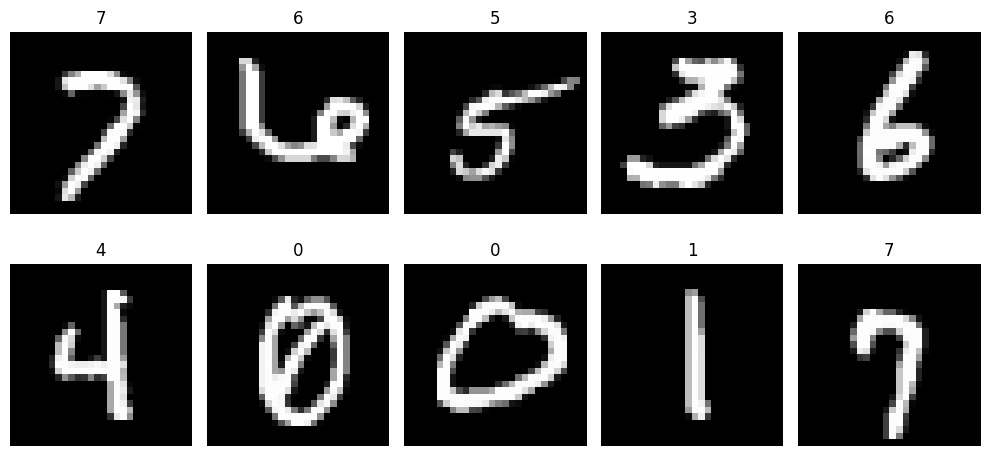

In [28]:
# Function to display images
def show_images(images, labels):
    plt.figure(figsize=(10, 5))
    for i in range(10):  # Display 10 images
        plt.subplot(2, 5, i + 1)
        img = images[i].view(1, 28, 28).numpy()  # Reshape back to (1, 28, 28)
        plt.imshow(img[0], cmap='gray')  # Show grayscale image
        plt.title(labels[i].numpy())  # Show the label
        plt.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

# # Get a batch of images and labels from the training subset
# images, labels = zip(*[train_subset[i] for i in range(10)])  # Get the first 10 images and labels

# # Convert to tensors
# images = torch.stack(images)
# labels = torch.tensor(labels)
images = torch.stack(train_images[10:20])
labels = torch.tensor(train_encodings[10:20])

# Show the images
show_images(images, labels)

#### Random Labels:
---

In [49]:
# # arranging simulant names so that more "similar" numbers (like 1 and 7) are represented by more similar chemicals (like DEM and DPM). 
# # Very informal, just to see if this idea is worth looking into
# #              0      1       2      3      4      5       6       7      
# chemicals = ['MES', 'DPM', 'TEPO', 'DEB', 'JP8', 'DtBP', 'DMMP', 'DEM']

# labeling images as chemical names instead of true class.
#              0      1       2      3      4      5       6       7 
chemicals = ['DEB', 'DEM', 'DMMP', 'DPM', 'DtBP', 'JP8', 'MES', 'TEPO']

# there are 8 classes in the simulant dataset,. Excluding '8' and '9' from MNIST so there will be 8 classes in this dataset as well.
exclude_classes = [8, 9]

# # randomly shuffling image labels and encodings
train_images = [element[0] for element in train_subset if not element[1] in exclude_classes]
train_encodings = [element[1] for element in train_subset if not element[1] in exclude_classes]
train_labels = [chemicals[element[1]] for element in train_subset if not element[1] in exclude_classes]
combined = list(zip(train_encodings, train_labels))
random.shuffle(combined)
train_encodings, train_labels = zip(*combined)

val_images = [element[0] for element in val_subset if not element[1] in exclude_classes]
val_encodings = [element[1] for element in val_subset if not element[1] in exclude_classes]
val_labels = [chemicals[element[1]] for element in val_subset if not element[1] in exclude_classes]
combined = list(zip(val_encodings, val_labels))
random.shuffle(combined)
val_encodings, val_labels = zip(*combined)

test_images = [element[0] for element in testset if not element[1] in exclude_classes]
test_encodings = [element[1] for element in testset if not element[1] in exclude_classes]
test_labels = [chemicals[element[1]] for element in testset if not element[1] in exclude_classes]
combined = list(zip(test_encodings, test_labels))
random.shuffle(combined)
test_encodings, test_labels = zip(*combined)

In [50]:
random_labels_train_embeddings_tensor, random_labels_train_image_tensor, random_labels_train_chem_encodings_tensor = create_dataset_tensors(
    train_images, 
    name_smiles_embedding_df,
    train_labels, 
    train_encodings,
    device
    )

random_labels_val_embeddings_tensor, random_labels_val_image_tensor, random_labels_val_chem_encodings_tensor = create_dataset_tensors(
    val_images, 
    name_smiles_embedding_df,
    val_labels, 
    val_encodings,
    device
    )

random_labels_test_embeddings_tensor, random_labels_test_image_tensor, random_labels_test_chem_encodings_tensor = create_dataset_tensors(
    test_images, 
    name_smiles_embedding_df,
    test_labels, 
    test_encodings,
    device
    )

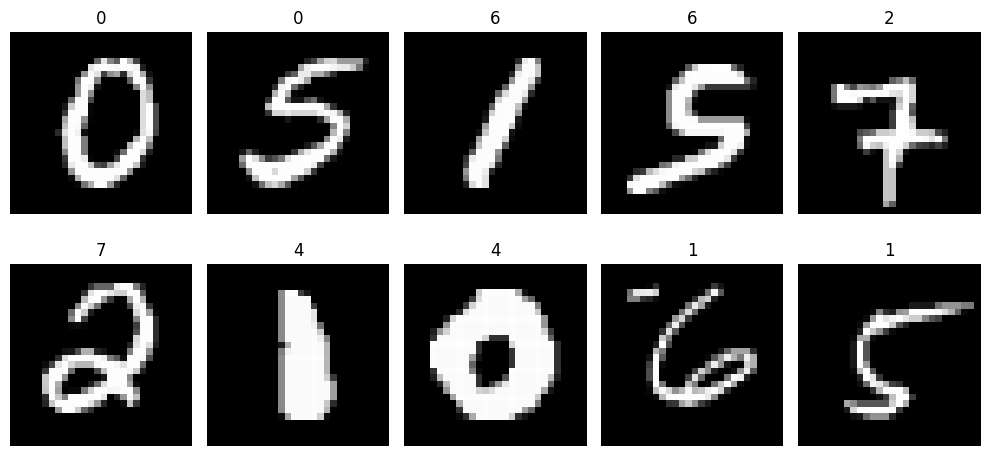

In [ ]:
# Function to display images
def show_images(images, labels):
    plt.figure(figsize=(10, 5))
    for i in range(10):  # Display 10 images
        plt.subplot(2, 5, i + 1)
        img = images[i].view(1, 28, 28).numpy()  # Reshape back to (1, 28, 28)
        plt.imshow(img[0], cmap='gray')  # Show grayscale image
        plt.title(labels[i].numpy())  # Show the label
        plt.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

images = torch.stack(train_images[10:20])
labels = torch.tensor(train_encodings[10:20])

# Show the images
show_images(images, labels)

#### Random Noise Instead of Images:
---

In [52]:
# labeling images as chemical names instead of true class.
# chemicals = ['DEB', 'DEM', 'DMMP', 'DPM', 'DtBP', 'JP8', 'MES', 'TEPO']

# there are 8 classes in the simulant dataset,. Excluding '8' and '9' from MNIST so there will be 8 classes in this dataset as well.
exclude_classes = [8, 9]

# could I do this for the entire dataset instead of just first 10? images, labels = zip(*[train_subset[i] for i in range(10)])
train_images = [torch.Tensor(np.random.uniform(low=-1.0, high=1.0, size=len(element[0]))) for element in train_subset if not element[1] in exclude_classes]
train_encodings = [element[1] for element in train_subset if not element[1] in exclude_classes]
train_labels = [chemicals[element[1]] for element in train_subset if not element[1] in exclude_classes]

val_images = [torch.Tensor(np.random.uniform(low=-1.0, high=1.0, size=len(element[0]))) for element in val_subset if not element[1] in exclude_classes]
val_encodings = [element[1] for element in val_subset if not element[1] in exclude_classes]
val_labels = [chemicals[element[1]] for element in val_subset if not element[1] in exclude_classes]

test_images = [torch.Tensor(np.random.uniform(low=-1.0, high=1.0, size=len(element[0]))) for element in testset if not element[1] in exclude_classes]
test_encodings = [element[1] for element in testset if not element[1] in exclude_classes]
test_labels = [chemicals[element[1]] for element in testset if not element[1] in exclude_classes]

In [53]:
random_noise_train_embeddings_tensor, random_noise_train_image_tensor, random_noise_train_chem_encodings_tensor = create_dataset_tensors(
    train_images, 
    name_smiles_embedding_df,
    train_labels, 
    train_encodings,
    device
    )

random_noise_val_embeddings_tensor, random_noise_val_image_tensor, random_noise_val_chem_encodings_tensor = create_dataset_tensors(
    val_images, 
    name_smiles_embedding_df,
    val_labels, 
    val_encodings,
    device
    )

random_noise_test_embeddings_tensor, random_noise_test_image_tensor, random_noise_test_chem_encodings_tensor = create_dataset_tensors(
    test_images, 
    name_smiles_embedding_df,
    test_labels, 
    test_encodings,
    device
    )

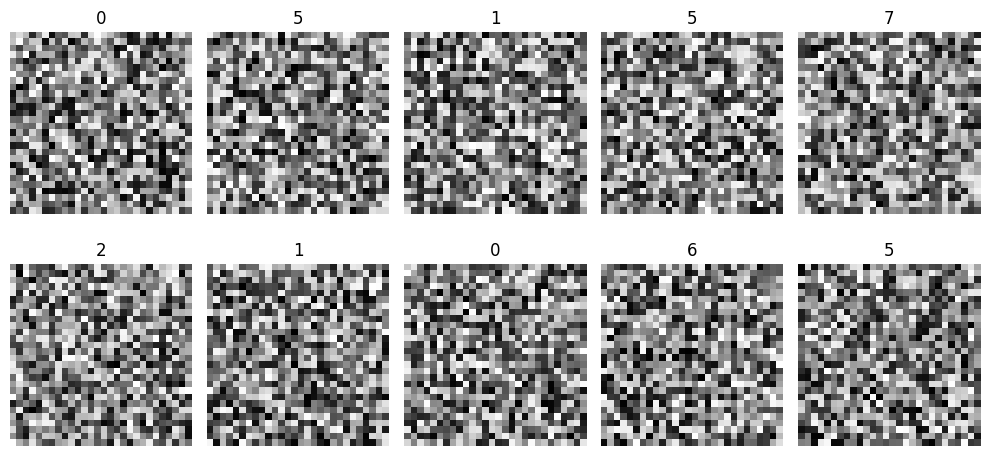

In [44]:
# Function to display images
def show_images(images, labels):
    plt.figure(figsize=(10, 5))
    for i in range(10):  # Display 10 images
        plt.subplot(2, 5, i + 1)
        img = images[i].view(1, 28, 28).numpy()  # Reshape back to (1, 28, 28)
        plt.imshow(img[0], cmap='gray')  # Show grayscale image
        plt.title(labels[i].numpy())  # Show the label
        plt.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()
    
images = torch.stack(train_images[10:20])
labels = torch.tensor(train_encodings[10:20])

# Show the images
show_images(images, labels)

# Train Encoder:
---

## Correctly Labeled Images:
---

In [29]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/data_preprocessing/mnist_encoder.ipynb'

In [ ]:
wandb_kwargs = {
    'architecture':'mnist_encoder',
    'optimizer':'AdamW',
    'loss':'MSELoss',
    'dataset':'MNIST',
    'target_embedding':'ChemNet'
}

model_hyperparams = {
  'batch_size':[64],
  'epochs': [1],
  'learning_rate':[.0001]
  }

encoder_path = '../models/ims_to_chemnet_encoder.pth'

train_data = TensorDataset(train_image_tensor, train_chem_encodings_tensor, train_embeddings_tensor)
val_data = TensorDataset(val_image_tensor, val_chem_encodings_tensor, val_embeddings_tensor)
test_data = TensorDataset(test_image_tensor, test_chem_encodings_tensor, test_embeddings_tensor)

encoder = Encoder().to(device)

best_hyperparams = train_model(
    encoder, train_data, val_data, device, config, wandb_kwargs, 
    name_smiles_embedding_df, model_hyperparams, chemicals, encoder_path, save_emb_pca_to_wandb=False, 
    )

Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  64
epochs  :  1
learning_rate  :  0.0001
Saved best model at epoch 1
-------------------------------------------
-------------------------------------------
Dataset:  IMS
Target Embeddings:  ChemNet
-------------------------------------------
-------------------------------------------
Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=716, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=716, out_features=648, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=648, out_features=580, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=580, out_features=512, bias=True)
  )
)
-------------------------------------------
-------------------------------------------


Encoder Training Loss,▁
Encoder Validation Loss,▁
Encoder Training Loss,0.00942
Encoder Validation Loss,0.00323


Hyperparameters for best model: 
    batch_size  :  64
    epochs  :  1
    learning_rate  :  0.0001


In [35]:
best_model = Encoder().to(device)
best_model.load_state_dict(torch.load(encoder_path))
encoder_criterion = nn.MSELoss()

Train Loss:  0.003036530188572088


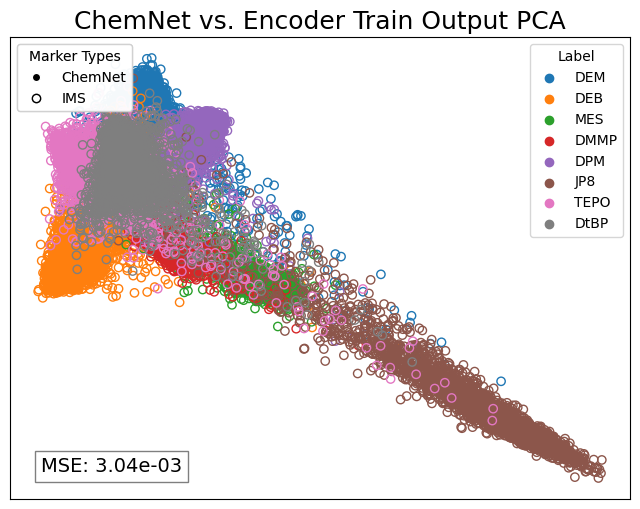

In [44]:
train_dataset = DataLoader(
    train_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=True
    )

train_preds, train_name_encodings, train_avg_loss = predict_embeddings(train_dataset, best_model, device, encoder_criterion)
train_true_embeddings, train_predicted_embeddings_flattened, train_chem_names = preds_to_emb_pca_plot(
    train_preds, train_name_encodings, chemicals, name_smiles_embedding_df,  
    )
train_preds_df = pd.DataFrame(train_predicted_embeddings_flattened)
train_preds_df['Label'] = train_chem_names

print('Train Loss: ', train_avg_loss)
plot_emb_pca(
    all_true_embeddings, train_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=train_true_embeddings, 
    title='ChemNet vs. Encoder Train Output PCA',
    mse_insert=train_avg_loss
    )

Validation Loss:  0.003228963351197886


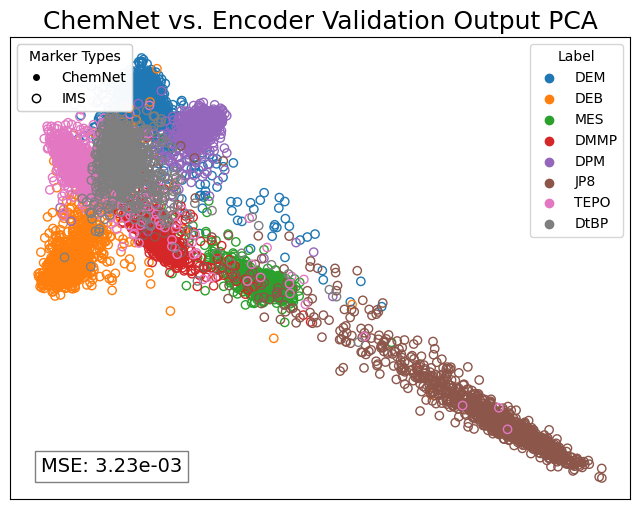

In [45]:
val_dataset = DataLoader(
    val_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=False
    )

val_preds, val_name_encodings, val_avg_loss = predict_embeddings(val_dataset, best_model, device, encoder_criterion)
val_true_embeddings, val_predicted_embeddings_flattened, val_chem_names = preds_to_emb_pca_plot(
    val_preds, val_name_encodings, chemicals, name_smiles_embedding_df,  
    )
val_preds_df = pd.DataFrame(val_predicted_embeddings_flattened)
val_preds_df['Label'] = val_chem_names

print('Validation Loss: ', val_avg_loss)
plot_emb_pca(
    all_true_embeddings, val_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=val_true_embeddings, 
    title='ChemNet vs. Encoder Validation Output PCA',
    mse_insert=val_avg_loss
    )

Test Loss:  0.002990627089895988


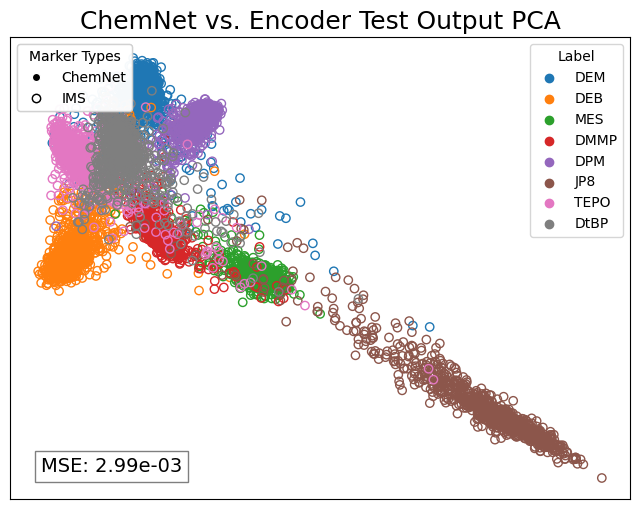

In [47]:
test_dataset = DataLoader(
    test_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=False
    )

test_preds, test_name_encodings, test_avg_loss = predict_embeddings(test_dataset, best_model, device, encoder_criterion)
test_true_embeddings, test_predicted_embeddings_flattened, test_chem_names = preds_to_emb_pca_plot(
    test_preds, test_name_encodings, chemicals, name_smiles_embedding_df,  
    )
test_preds_df = pd.DataFrame(test_predicted_embeddings_flattened)
test_preds_df['Label'] = test_chem_names

print('Test Loss: ', test_avg_loss)
plot_emb_pca(
    all_true_embeddings, test_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=test_true_embeddings, 
    title='ChemNet vs. Encoder Test Output PCA',
    mse_insert=test_avg_loss
    )

## Randomly Labeled Images:
---

In [ ]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/data_preprocessing/cifar10_encoder.ipynb'

In [51]:
wandb_kwargs = {
    'architecture':'mnist_random_labels_encoder',
    'optimizer':'AdamW',
    'loss':'MSELoss',
    'dataset':'MNIST',
    'target_embedding':'ChemNet'
}

model_hyperparams = {
  'batch_size':[64],
  'epochs': [1],
  'learning_rate':[.0001]
  }

encoder_path = '../models/ims_to_chemnet_encoder.pth'

train_data = TensorDataset(random_labels_train_image_tensor, random_labels_train_chem_encodings_tensor, random_labels_train_embeddings_tensor)
val_data = TensorDataset(random_labels_val_image_tensor, random_labels_val_chem_encodings_tensor, random_labels_val_embeddings_tensor)
test_data = TensorDataset(random_labels_test_image_tensor, random_labels_test_chem_encodings_tensor, random_labels_test_embeddings_tensor)

encoder = Encoder().to(device)

best_hyperparams = train_model(
    encoder, train_data, val_data, device, config, wandb_kwargs, 
    name_smiles_embedding_df, model_hyperparams, chemicals, encoder_path, save_emb_pca_to_wandb=False, 
    )

Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  64
epochs  :  1
learning_rate  :  0.0001
Saved best model at epoch 1
-------------------------------------------
-------------------------------------------
Dataset:  MNIST
Target Embeddings:  ChemNet
-------------------------------------------
-------------------------------------------
Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=716, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=716, out_features=648, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=648, out_features=580, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=580, out_features=512, bias=True)
  )
)
-------------------------------------------
-------------------------------------------


Encoder Training Loss,▁
Encoder Validation Loss,▁
Encoder Training Loss,0.03097
Encoder Validation Loss,0.02973


Hyperparameters for best model: 
    batch_size  :  64
    epochs  :  1
    learning_rate  :  0.0001


In [ ]:
best_model = Encoder().to(device)
best_model.load_state_dict(torch.load(encoder_path))
encoder_criterion = nn.MSELoss()

Train Loss:  0.003036530188572088


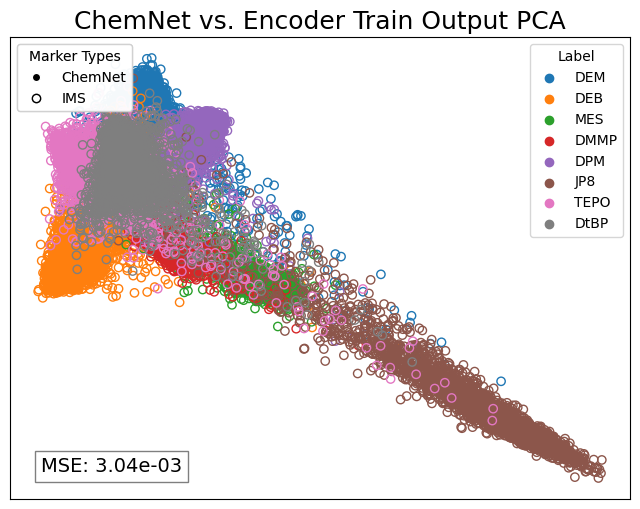

In [ ]:
train_dataset = DataLoader(
    train_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=True
    )

train_preds, train_name_encodings, train_avg_loss = predict_embeddings(train_dataset, best_model, device, encoder_criterion)
train_true_embeddings, train_predicted_embeddings_flattened, train_chem_names = preds_to_emb_pca_plot(
    train_preds, train_name_encodings, chemicals, name_smiles_embedding_df,  
    )
train_preds_df = pd.DataFrame(train_predicted_embeddings_flattened)
train_preds_df['Label'] = train_chem_names

print('Train Loss: ', train_avg_loss)
plot_emb_pca(
    all_true_embeddings, train_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=train_true_embeddings, 
    title='ChemNet vs. Encoder Train Output PCA',
    mse_insert=train_avg_loss
    )

Validation Loss:  0.003228963351197886


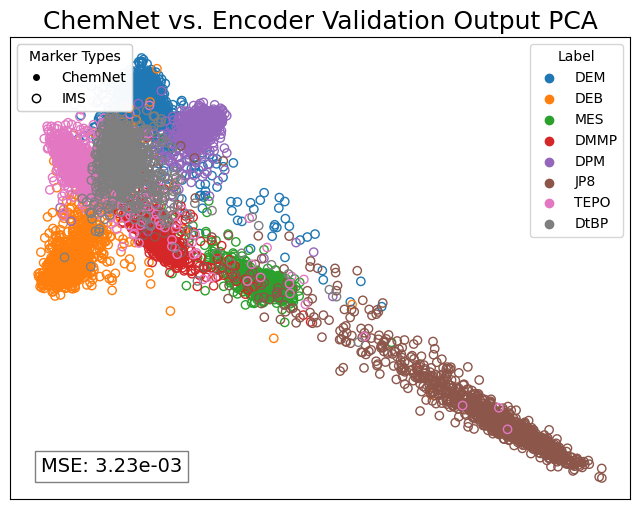

In [ ]:
val_dataset = DataLoader(
    val_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=False
    )

val_preds, val_name_encodings, val_avg_loss = predict_embeddings(val_dataset, best_model, device, encoder_criterion)
val_true_embeddings, val_predicted_embeddings_flattened, val_chem_names = preds_to_emb_pca_plot(
    val_preds, val_name_encodings, chemicals, name_smiles_embedding_df,  
    )
val_preds_df = pd.DataFrame(val_predicted_embeddings_flattened)
val_preds_df['Label'] = val_chem_names

print('Validation Loss: ', val_avg_loss)
plot_emb_pca(
    all_true_embeddings, val_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=val_true_embeddings, 
    title='ChemNet vs. Encoder Validation Output PCA',
    mse_insert=val_avg_loss
    )

Test Loss:  0.002990627089895988


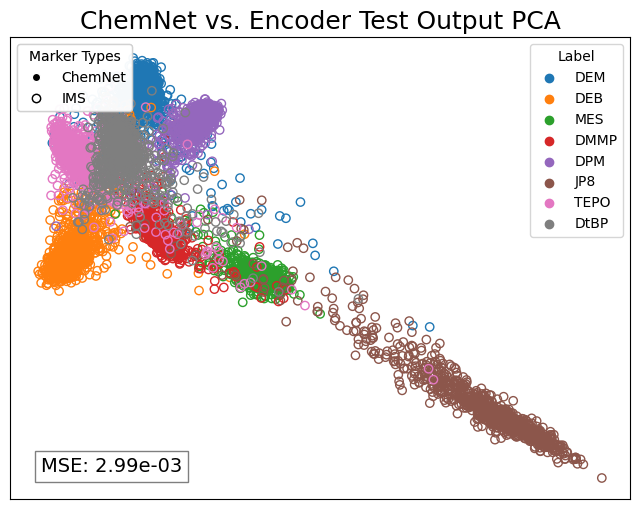

In [ ]:
test_dataset = DataLoader(
    test_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=False
    )

test_preds, test_name_encodings, test_avg_loss = predict_embeddings(test_dataset, best_model, device, encoder_criterion)
test_true_embeddings, test_predicted_embeddings_flattened, test_chem_names = preds_to_emb_pca_plot(
    test_preds, test_name_encodings, chemicals, name_smiles_embedding_df,  
    )
test_preds_df = pd.DataFrame(test_predicted_embeddings_flattened)
test_preds_df['Label'] = test_chem_names

print('Test Loss: ', test_avg_loss)
plot_emb_pca(
    all_true_embeddings, test_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=test_true_embeddings, 
    title='ChemNet vs. Encoder Test Output PCA',
    mse_insert=test_avg_loss
    )

## Randomly Noise Instead of Images:
---

In [47]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/data_preprocessing/cifar10_encoder.ipynb'

In [54]:
wandb_kwargs = {
    'architecture':'mnist_random_noise_encoder',
    'optimizer':'AdamW',
    'loss':'MSELoss',
    'dataset':'MNIST',
    'target_embedding':'ChemNet'
}

model_hyperparams = {
  'batch_size':[64],
  'epochs': [1],
  'learning_rate':[.0001]
  }

encoder_path = '../models/ims_to_chemnet_encoder.pth'

train_data = TensorDataset(random_noise_train_image_tensor, random_noise_train_chem_encodings_tensor, random_noise_train_embeddings_tensor)
val_data = TensorDataset(random_noise_val_image_tensor, random_noise_val_chem_encodings_tensor, random_noise_val_embeddings_tensor)
test_data = TensorDataset(random_noise_test_image_tensor, random_noise_test_chem_encodings_tensor, random_noise_test_embeddings_tensor)

encoder = Encoder().to(device)

best_hyperparams = train_model(
    encoder, train_data, val_data, device, config, wandb_kwargs, 
    name_smiles_embedding_df, model_hyperparams, chemicals, encoder_path, save_emb_pca_to_wandb=False, 
    )

Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  64
epochs  :  1
learning_rate  :  0.0001
Saved best model at epoch 1
-------------------------------------------
-------------------------------------------
Dataset:  MNIST
Target Embeddings:  ChemNet
-------------------------------------------
-------------------------------------------
Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=716, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=716, out_features=648, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=648, out_features=580, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=580, out_features=512, bias=True)
  )
)
-------------------------------------------
-------------------------------------------


Encoder Training Loss,▁
Encoder Validation Loss,▁
Encoder Training Loss,0.03162
Encoder Validation Loss,0.02989


Hyperparameters for best model: 
    batch_size  :  64
    epochs  :  1
    learning_rate  :  0.0001


In [ ]:
best_model = Encoder().to(device)
best_model.load_state_dict(torch.load(encoder_path))
encoder_criterion = nn.MSELoss()

Train Loss:  0.003036530188572088


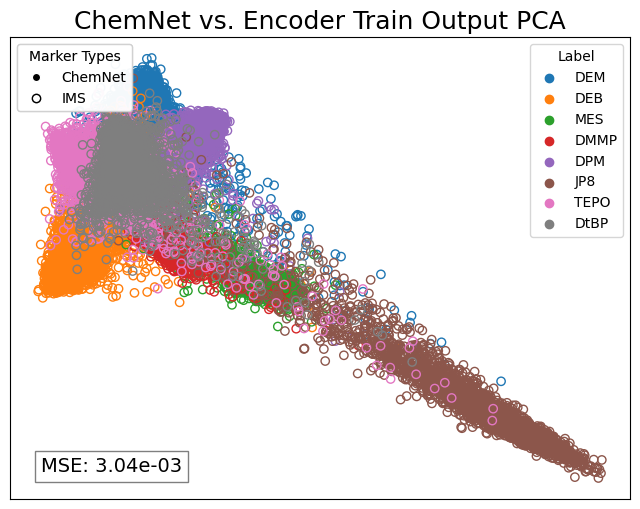

In [ ]:
train_dataset = DataLoader(
    train_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=True
    )

train_preds, train_name_encodings, train_avg_loss = predict_embeddings(train_dataset, best_model, device, encoder_criterion)
train_true_embeddings, train_predicted_embeddings_flattened, train_chem_names = preds_to_emb_pca_plot(
    train_preds, train_name_encodings, chemicals, name_smiles_embedding_df,  
    )
train_preds_df = pd.DataFrame(train_predicted_embeddings_flattened)
train_preds_df['Label'] = train_chem_names

print('Train Loss: ', train_avg_loss)
plot_emb_pca(
    all_true_embeddings, train_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=train_true_embeddings, 
    title='ChemNet vs. Encoder Train Output PCA',
    mse_insert=train_avg_loss
    )

Validation Loss:  0.003228963351197886


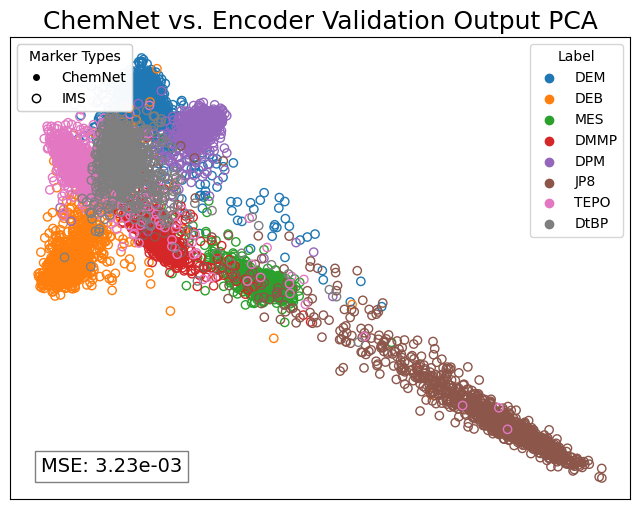

In [ ]:
val_dataset = DataLoader(
    val_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=False
    )

val_preds, val_name_encodings, val_avg_loss = predict_embeddings(val_dataset, best_model, device, encoder_criterion)
val_true_embeddings, val_predicted_embeddings_flattened, val_chem_names = preds_to_emb_pca_plot(
    val_preds, val_name_encodings, chemicals, name_smiles_embedding_df,  
    )
val_preds_df = pd.DataFrame(val_predicted_embeddings_flattened)
val_preds_df['Label'] = val_chem_names

print('Validation Loss: ', val_avg_loss)
plot_emb_pca(
    all_true_embeddings, val_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=val_true_embeddings, 
    title='ChemNet vs. Encoder Validation Output PCA',
    mse_insert=val_avg_loss
    )

Test Loss:  0.002990627089895988


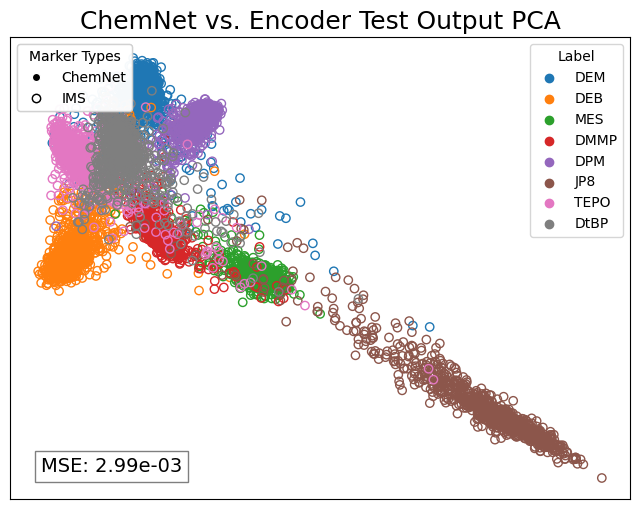

In [ ]:
test_dataset = DataLoader(
    test_data, 
    batch_size=best_hyperparams['batch_size'], 
    shuffle=False
    )

test_preds, test_name_encodings, test_avg_loss = predict_embeddings(test_dataset, best_model, device, encoder_criterion)
test_true_embeddings, test_predicted_embeddings_flattened, test_chem_names = preds_to_emb_pca_plot(
    test_preds, test_name_encodings, chemicals, name_smiles_embedding_df,  
    )
test_preds_df = pd.DataFrame(test_predicted_embeddings_flattened)
test_preds_df['Label'] = test_chem_names

print('Test Loss: ', test_avg_loss)
plot_emb_pca(
    all_true_embeddings, test_preds_df, 
    log_wandb=False, chemnet_embeddings_to_plot=test_true_embeddings, 
    title='ChemNet vs. Encoder Test Output PCA',
    mse_insert=test_avg_loss
    )